In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import pickle as pkl
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels.api as sm
from sklearn import metrics


In [2]:
machine = "local"

if machine == 'Snellius':
    pred_var_path = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/' # For retrieving the set of aggregated scaling vectors

    save_dir = pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/' # used for storing the trained model
elif machine == "local":
    pred_var_path = './' # For retrieving the set of aggregated scaling vectors

    save_dir = pers_file_dir = './trained_models/' # used for storing the trained model

In [17]:
with xr.open_dataset(pred_var_path + 'vars_per_eco_monthly_anomaly.nc') as ds:
    complete_ds = ds.drop_vars(['regions', 'grid_cell_weight', 'grid_cell_area', 'TER', 'monthly_flux', 'smoothed_flux', 'opt_flux',
                    'prior_flux_per_s', 'scaling_factor', 'monthly_sf', 'smoothed_sf', 'eco_area', 'ci_AVG'])

large_eco_regions = [1.0, 7.0, 9.0, 19.0, 20.0, 23.0, 33.0, 191.0, 200.0, 204.0, 209.0]

pruned_ds = complete_ds.where(complete_ds.eco_regions.isin(large_eco_regions), drop=True)

print(pruned_ds)

# before moving forward, some data is put aside to be used for model validation later. Going for the classical 80-20% split

train_ds = pruned_ds.loc[dict(time=slice("2000-01-01","2017-01-01"))]
print(train_ds)

test_ds = pruned_ds.loc[dict(time=slice("2017-01-01","2021-01-01"))]
print(test_ds)

vars = ['']*36
aggr = ['']*36
for i, var in enumerate(list(test_ds.drop('sf_per_eco').data_vars)):
    print(var.split('_'))
    vars[i], aggr[i] = str(var).split('_')
print(np.unique(vars))
print(len(np.unique(vars)))
print(aggr)

<xarray.Dataset>
Dimensions:      (eco_regions: 11, time: 1096, lon: 360, lat: 180)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
  * lon          (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * eco_regions  (eco_regions) float64 1.0 7.0 9.0 19.0 ... 200.0 204.0 209.0
Data variables: (12/37)
    sf_per_eco   (eco_regions, time) float32 0.2209 0.7194 ... 0.8827 0.9176
    g10m_MAX     (eco_regions, time) float64 0.0 0.3509 -0.7395 ... -3.116 2.939
    swvl1_MIN    (eco_regions, time) float64 0.0 -0.0001536 ... 0.00195
    swvl1_MAX    (eco_regions, time) float64 0.0 -0.002324 ... 0.002162
    slhf_MIN     (eco_regions, time) float64 0.0 -4.385 6.693 ... 47.35 -25.49
    slhf_MAX     (eco_regions, time) float64 0.0 -2.097 -1.597 ... 10.18 -18.84
    ...           ...
    cp_SUM       (eco_regions, time) float64 0.0 -5.374e-08 ... 2.69e-06
    sd_MI

# Finding the hyper-parameters

For this SARIMAX implementation, the same hyperparameters used for the SARIMA part are used. The goal of this notebook is to determine which exogeonous (or predictor) variables are most suited for being used within the SARIMAX model. This will be done in a way similar to the hyperpatermeter fitting of SARIMA. By using an auto-correlation function (ACF), the varibales with the highest correlation to the scaling factor can be determined. A high correlation does not entail causation, but the set of variables used are already considered to be potential determinents of the scaling factor. While this relation is not proven, it for now provides grounds to assume a causal relation.

In [15]:
r_dict_abs = {}

for var in train_ds.drop_vars(['sf_per_eco']).data_vars: # Drop the sf_per_eco var.
    # xr.plot.scatter(train_ds.loc[dict(eco_regions=7.0)], x=var, y='sf_per_eco')
    # plt.show()
    r_dict_abs[var] = xr.corr(train_ds['sf_per_eco'], np.fabs(train_ds[var]), dim="time")
    print(f'Pearson correlation of var {var}: {r_dict_abs[var]}')

Pearson correlation of var g10m_MAX: [-0.03352111 -0.05481644 -0.01024699  0.00085723  0.03042531  0.01583914
 -0.00752363  0.00012711 -0.03888201  0.03314192  0.02382612]
Pearson correlation of var swvl1_MIN: [-0.03699684 -0.11126525  0.02007486 -0.0024334   0.11237336  0.02294387
 -0.00945699  0.00922967  0.07624801  0.04896992 -0.01268167]
Pearson correlation of var swvl1_MAX: [-0.02205271 -0.05895573  0.0090359  -0.03112196  0.09342162  0.05125244
 -0.01354342 -0.00357694  0.0534893   0.00663142  0.0013601 ]
Pearson correlation of var slhf_MIN: [-0.02465429 -0.02801437  0.05715238  0.04887778  0.07712139 -0.0150594
  0.02234507 -0.03345199  0.03843855 -0.01333325  0.05089152]
Pearson correlation of var slhf_MAX: [-0.03721488  0.09075038 -0.01375725  0.02271957 -0.04145168  0.02093662
 -0.02563799 -0.06643177  0.03171012  0.00465839  0.02162524]
Pearson correlation of var slhf_AVG: [-0.01986208 -0.04196355  0.07891164  0.04877383  0.04614152 -0.02992746
  0.0438977  -0.00540765  0.0

In [50]:
r_dict = {}

for var in train_ds.drop_vars(['sf_per_eco']).data_vars: # skip the first var because that is the actual scaling factor
    # xr.plot.scatter(train_ds.loc[dict(eco_regions=7.0)], x=var, y='sf_per_eco')
    # plt.show()
    r_dict[var] = xr.corr(train_ds['sf_per_eco'], train_ds[var], dim="time")
    print(f'Pearson correlation of var {var}: {r_dict[var]}')

np.max(np.fabs(list(r_dict.values())))

Pearson correlation of var g10m_MAX: [-0.00260858 -0.01157899  0.00948854  0.01539623  0.01675444  0.01417311
  0.03687758 -0.05873305 -0.02690554  0.01569373 -0.03240946]
Pearson correlation of var swvl1_MIN: [-0.05627707  0.09852739  0.01267905  0.02032796  0.00730863  0.03073782
 -0.02914674  0.03329732  0.00610957 -0.01801661  0.0104327 ]
Pearson correlation of var swvl1_MAX: [-0.02768255  0.06956357 -0.00509532  0.01886542  0.00276463 -0.00176454
 -0.01356438  0.01423308 -0.00205299 -0.01220278  0.00671707]
Pearson correlation of var slhf_MIN: [ 0.01407425  0.06601387  0.01893451 -0.00974169  0.00100177  0.0198098
 -0.00591198  0.00738844 -0.08941079  0.03370019  0.00993647]
Pearson correlation of var slhf_MAX: [ 0.00531523 -0.09174997 -0.00799894  0.06275661 -0.05087842  0.03488875
  0.03755078 -0.04016474 -0.01159498 -0.01652414 -0.02028287]
Pearson correlation of var slhf_AVG: [-0.00872573  0.05818627  0.01258116  0.013469   -0.02066261  0.02957287
  0.00524335 -0.00640833 -0.0

0.10717396394988635

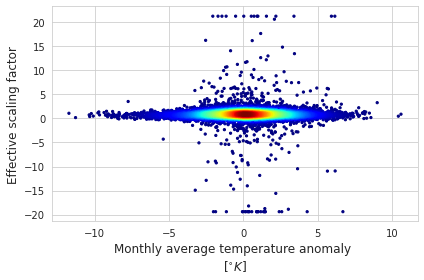

In [51]:
from scipy.stats import gaussian_kde


x = train_ds.t2m_AVG.values.flatten()
y = train_ds.sf_per_eco.values.flatten()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]


plt.scatter(x, y, c=z, s=5, cmap='jet')
plt.xlabel('Monthly average temperature anomaly \n'r'[$^{\circ}K$]', fontsize=12)
plt.ylabel('Effective scaling factor', fontsize=12)
plt.tight_layout()
plt.savefig('../figures/temp_anom_vs_sf.png')
plt.savefig('../figures/temp_anom_vs_sf.pdf')

/tmp/ipykernel_5023/4050270950.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bwr").copy()
  cmap.set_bad('black')


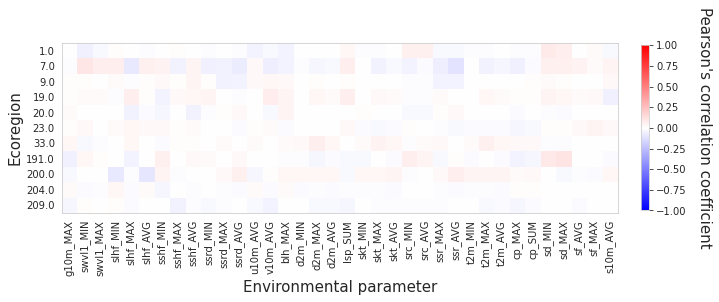

In [58]:
df = pd.DataFrame(data=r_dict, index=train_ds.eco_regions)
# DataFrame(abs(np.random.randn(5, 4)), index=index, columns=columns)

cmap = mpl.cm.get_cmap('bwr')
cmap.set_bad('black')
fig, ax = plt.subplots(figsize=(10,5))
im = plt.imshow(df, cmap=cmap, vmin=-1, vmax=1)
plt.grid(None)
plt.yticks(np.arange(0, len(df.index), 1), df.index)
plt.ylabel('Ecoregion', fontsize=15)
plt.xticks(np.arange(0, len(df.columns), 1), df.columns, rotation=90)
plt.xlabel('Environmental parameter', fontsize=15)

im_ratio = df.shape[0]/df.shape[1]
# plt.title('Correlation between environmental variables and \nthe scaling factor of various eco-regions', fontsize=20)
cbar = plt.colorbar(im, fraction=0.046*im_ratio, pad=0.04)
cbar.set_label("Pearson's correlation coefficient", rotation=270, fontsize=15, labelpad=25)
plt.tight_layout()
plt.savefig('../figures/corr_ceoff_vars.pdf')
plt.show()


In [ ]:
# For testing whether the data for each ecoregion is stationary, the augmented Dicky-Fuller test is used.
# This test is applied to each of ecoregions. No correction for multiple comparisons is applied. This could 
# result in 5% of the results rejecting the null-hypothesis when all null-hypoheses are false.

from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test

for region in train_ds.eco_regions:
    data = train_ds.sf_per_eco.loc[dict(eco_regions=region)]
    print(f'p-value for region {region.values}: {adfuller(data)[1]}')


For all regions, the null-hypothesis of a unit-root existing within the set of all scaling factors (i.e. there is an increase or decrease over time) is rejected. Therefore, both the d and D terms are set to 0, effectively creating a SARMA model. 

Next up is determining the other hyperparameters.

In [ ]:
# The second step is to find the values for p and P using ACF and PACF. Since analysing all 68 used ecoregions is 
# computationally expensive and not really necesarry, only the ecoregions from the transcom region deemed most reliable are 
# included in the analysis. This is the Europe transcom region, with has the ecoregions 191 to 209.

for region in train_ds.eco_regions.sel(eco_regions= slice(191.0, 210.0)):
    print(str(region.values))
    dat = train_ds.sf_per_eco.loc[dict(eco_regions=region)]
    fig, ax = plt.subplots(2,1, figsize=(8, 6))
    fig = sm.graphics.tsa.plot_acf(dat, lags=110, ax=ax[0])
    ax[0].vlines([52, 104], -1, 1, color='C09', linestyles='--', alpha=0.5)
    fig = sm.graphics.tsa.plot_pacf(dat, lags=110, ax=ax[1])
    ax[1].vlines([52, 104], -1, 1, color='C09', linestyles='--', label='Year line', alpha=0.5)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    plt.suptitle('eco-region: ' + str(region.values))
    plt.show()

# Conclusions ACF and PACF:
Lets first determine the AR terms of p and P. This is done by looking at the PACF plots.  Generally speaking, a peak is observed around lag=52 and lag=104. This correlates to a seasonal trend of a year. Next to the peaks at 52 and 104, some peaks are also observed at 52+1 and 104+1, indicating that the P should be either 0 or 1. Closer to lag=0, some models also show a peak at either lag=1, lag=2, or both. This indicated that the p value should be 2.

The ACF plots show a very similar trend. Therefore, the MA terms of q and Q are copied from their AR counter parts: q=2 and Q=1.

This means we arrive at our final model: ARIMA(p,d,q)(P,D,Q)<sub>s</sub> = ARIMA(2,0,2)(1,0,1)<sub>52</sub>

Furthermore, there is no reason to assume the scaling factor should be 0 at t=0. Hence, an intercept term is added as well.

In [ ]:
experiment_dir = './SARIMA_test_models/'

!ls -al SARIMA_test_models/

In [ ]:
for region in train_ds.eco_regions.sel(eco_regions= slice(191.0, 192.0)):
    print(str(region.values))
    data = train_ds.sf_per_eco.loc[dict(eco_regions=region)]
    model = sm.tsa.statespace.SARIMAX(data.values,
                                     order=(2,0,2),             # Defining the regular AR, I and MA dependencies
                                     seasonal_order=(1,0,1,52), # Defining the seasonal dependencies
                                     trend = 'c'                # Adding an intercept term
                                     )
    results=model.fit(maxiter=100) # method='cg'
    print(results.summary())
    
    file_name = str(region.values)
    file = experiment_dir + file_name + '.pkl'
    pkl.dump(results, open(file, "wb" ))
    print('\n Making prediction:')
#     fit_res = mod.fit()
    forecast = xr.DataArray(data = results.predict(start=800,end=887,dynamic=False), 
                            dims = ['time'],
                            coords = dict(time=data.time.isel(time=slice(800,888))),
                            name = 'forecast')
    xr.merge([data, forecast]).to_array().plot.line(x='time',figsize=(12,8))
    #data[['sf_per_eco','forecast']].plot(figsize=(12,8))


In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
# npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

test_ds.sel(eco_regions=191.0).plot.scatter(x='time',y='sf_per_eco', ax=ax, label='Observed', c='C00')
# Plot predictions
plt.plot(test_ds.time.values, predict.predicted_mean[888:], label='One-step-ahead forecast', c='C01')
ci = predict_ci[888:]
ax.fill_between(test_ds.time.values, ci[:,0], ci[:,1], color='C01', alpha=0.1)
plt.show()

In [ ]:

with open('./SARIMA_test_models/191.0.pkl', "rb") as file:
    trained_model = pkl.load(file)
trained_model.summary()

In [ ]:

with open('./SARIMA_test_models/192.0.pkl', "rb") as file:
    trained_model = pkl.load(file)
trained_model.summary()

In [ ]:

with open('./SARIMA_test_models/191.0.pkl', "rb") as file:
    trained_model = pkl.load(file)
complete_data = complete_ds.sf_per_eco.loc[dict(eco_regions='191.0')]
test_model = sm.tsa.statespace.SARIMAX(complete_data.values,
                                     order=(2,0,2),             # Defining the regular AR, I and MA dependencies
                                     seasonal_order=(1,0,1,52), # Defining the seasonal dependencies
                                     trend = 'c'                # Adding an intercept term
                                     )
results = test_model.filter(trained_model.params)
predict = results.get_prediction(start=888)
predict_ci = predict.conf_int()


file_name = 'test_191.0.pkl'
file = experiment_dir + file_name
pkl.dump(predict, open(file, "wb" ))

# Graph
fig, ax = plt.subplots(figsize=(9,4))
# npre = 4
ax.set(title='Prediction sf ecoregegion 191', xlabel='Date', ylabel='Scaling factor')

# Plot data points
# test_ds.plot.scatter(x='sf_per_eco', y='time', ax=ax, label='Observed')
test_ds.sel(eco_regions=191.0).plot.scatter(x='time',y='sf_per_eco', ax=ax, label='Observed', c='C00')
# Plot predictions
plt.plot(test_ds.time.values, predict.predicted_mean, label='One-step-ahead forecast', c='C01')
ci = predict_ci
ax.fill_between(test_ds.time.values, ci[:,0], ci[:,1], color='C01', alpha=0.1)
# predict_dy.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
# ci = predict_dy_ci.loc['1977-07-01':]
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

plt.show()

# forecast = xr.DataArray(data = model.predict(start=800,end=887,dynamic=False), 
#                             dims = ['time'],
#                             coords = dict(time=data.time.isel(time=slice(800,888))),
#                             name = 'forecast')
# xr.merge([data, forecast]).to_array().plot.line(x='time',figsize=(12,8))
# plt.show()


with open('./SARIMA_test_models/192.0.pkl', "rb") as file:
    model = pkl.load(file)
complete_data = complete_ds.sf_per_eco.loc[dict(eco_regions='192.0')]
test_model = sm.tsa.statespace.SARIMAX(complete_data.values,
                                     order=(2,0,2),             # Defining the regular AR, I and MA dependencies
                                     seasonal_order=(1,0,1,52), # Defining the seasonal dependencies
                                     trend = 'c'                # Adding an intercept term
                                     )
results = test_model.filter(trained_model.params)
predict = results.get_prediction(start=888)
predict_ci = predict.conf_int()


file_name = 'test_192.0.pkl'
file = experiment_dir + file_name
pkl.dump(predict, open(file, "wb" ))


# Graph
fig, ax = plt.subplots(figsize=(9,4))
# npre = 4
ax.set(title='Prediction sf ecoregegion 192', xlabel='Date', ylabel='Scaling factor')

# Plot data points
# test_ds.plot.scatter(x='sf_per_eco', y='time', ax=ax, label='Observed')
test_ds.sel(eco_regions=192.0).plot.scatter(x='time',y='sf_per_eco', ax=ax, label='Observed', c='C00')
# Plot predictions
plt.plot(test_ds.time.values, predict.predicted_mean, label='One-step-ahead forecast', c='C01')
ci = predict_ci
ax.fill_between(test_ds.time.values, ci[:,0], ci[:,1], color='C01', alpha=0.1)
# predict_dy.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
# ci = predict_dy_ci.loc['1977-07-01':]
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

plt.show()

In [ ]:
MAPE = metrics.mean_absolute_percentage_error(test_ds.sel(eco_regions=192.0).sf_per_eco.values, predict.predicted_mean)
RMSE = np.sqrt(metrics.mean_squared_error(test_ds.sel(eco_regions=192.0).sf_per_eco.values, predict.predicted_mean))
r2 = metrics.r2_score(test_ds.sel(eco_regions=192.0).sf_per_eco.values, predict.predicted_mean)

print(f'MAPE:{MAPE*100}%')
print(f'RMSE:{RMSE}')
print(f'R^2:{r2}')

In [ ]:
str(complete_data.time.dt.year.min().values)

In [ ]:
with open('./SARIMA_test_models/test_192.0.pkl', "rb") as file:
    results_192 = pkl.load(file)

true_dat = test_ds.sel(eco_regions=191.0).sf_per_eco.values
pred_dat = results_192.predicted_mean
flux_dat = test_ds.sel(eco_regions=191.0).prior_flux_per_s.values
for item in eval_model
print(eval_model(true_dat, pred_dat, flux_dat))


In [11]:

with open('./SARIMA_test_models/test_191.0.pkl', "rb") as file:
    results_191 = pkl.load(file)

true_dat = test_ds.sel(eco_regions=191.0).sf_per_eco.values
pred_dat = results_191.predicted_mean
flux_dat = test_ds.sel(eco_regions=191.0).prior_flux_per_s.values
print(eval_model(true_dat, pred_dat, flux_dat))


{'sf_ME': 0.11438042389738999, 'sf_MAPE': 1.8131300227381466, 'sf_RMSE': 0.9641062218468168, 'sf_r2': -0.014308024992293111, 'flux_ME': 35449.08136795087, 'flux_MAPE': 1.8131300141741657, 'flux_RMSE': 902066.5264112586, 'flux_r2': 0.7863753902447552}


In [12]:
with open('./SARIMA_test_models/test_192.0.pkl', "rb") as file:
    results_192 = pkl.load(file)

true_dat = test_ds.sel(eco_regions=191.0).sf_per_eco.values
pred_dat = results_192.predicted_mean
flux_dat = test_ds.sel(eco_regions=191.0).prior_flux_per_s.values
for item in eval_model
print(eval_model(true_dat, pred_dat, flux_dat))


{'sf_ME': 0.06129099044875648, 'sf_MAPE': 1.7907201207372365, 'sf_RMSE': 0.9315941029122636, 'sf_r2': 0.052948596852753105, 'flux_ME': -49910.47472931731, 'flux_MAPE': 1.7907201157669979, 'flux_RMSE': 1007592.3554717938, 'flux_r2': 0.7334713649399089}


Text(0.5, 0, 'time')

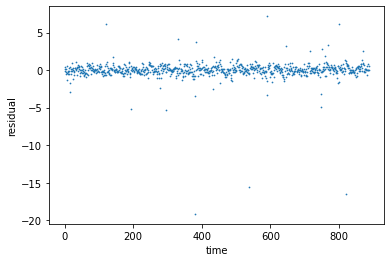

In [18]:
plt.scatter(range(len(trained_model.resid)), trained_model.resid, s=0.5)
plt.ylabel('residual')
plt.xlabel('time')

Text(0.5, 0, 'residual value')

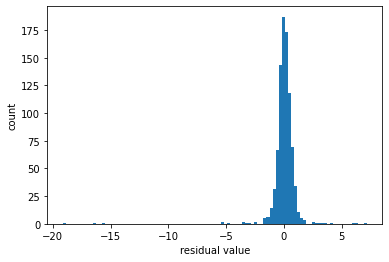

In [19]:
plt.hist(trained_model.resid, bins=100)
plt.ylabel('count')
plt.xlabel('residual value')

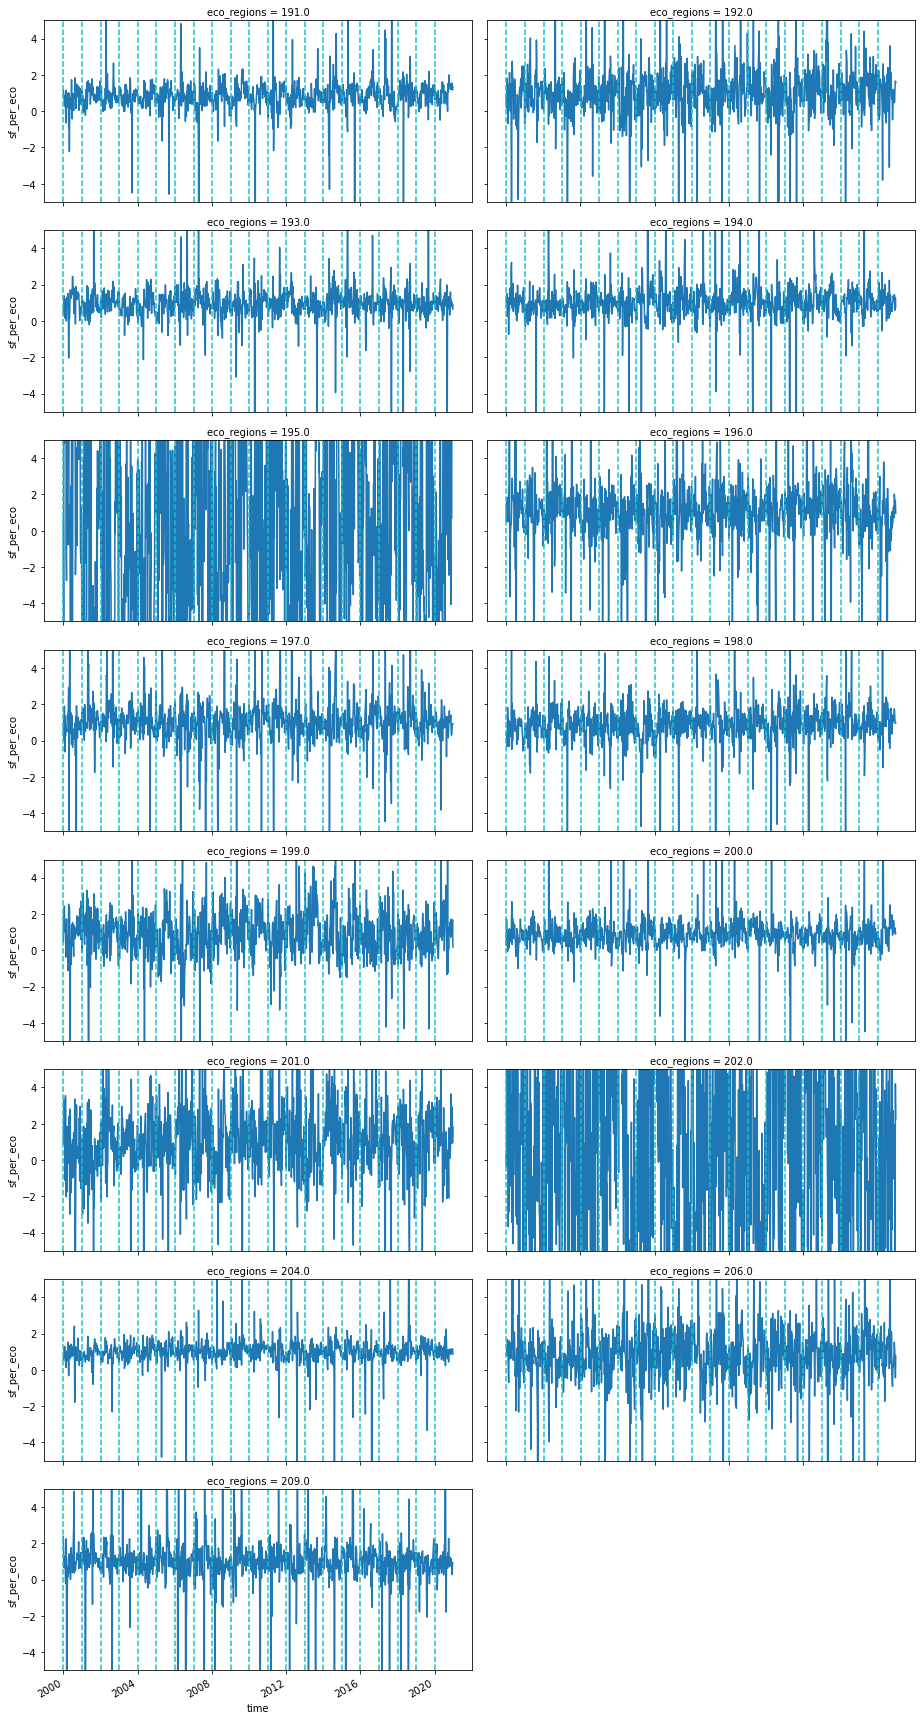

In [29]:
fig = complete_ds.sf_per_eco.sel(eco_regions=slice(191, 210)).plot(aspect=2, size=3, col="eco_regions", col_wrap=2)
dates = pd.DatetimeIndex(complete_ds.time.values)

line_dates = dates.where((dates.day <= 7) & (dates.month == 1))
for row_ax in fig.axes:
    # Add vertical lines to indicate the start of every year
    for ax in row_ax:
        ax.vlines(line_dates, -5, 5, color='C09', linestyles='--', label='year line')

plt.ylim((-5, 5))
plt.legend()